In [1]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 66 kB 786 kB/s 
     |████████████████████████████████| 58 kB 2.1 MB/s 
     |████████████████████████████████| 244 kB 4.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=0f1a4627ff268ecea1285a962898a4a5d585e06edfbdf4ffe61d8351d26f3744
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=162e68b7c455443bad83189de7b9e1f45f6b140b34b4ba2c4e2a69f64482b825
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pathlib
import os
import random
import time
import cv2
import gc 
from tqdm.notebook import tqdm 
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

#data structure
import pandas as pd

#graphics
import matplotlib.pyplot as plt
%matplotlib inline

#tiff file
import rasterio 
from rasterio.windows import Window 

#models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

#data augmentation
import albumentations as A 
import torchvision
from torchvision import transforms as T

In [3]:
def set_seeds(seed=21):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
BASE_DIR = '../input/hubmap-kidney-segmentation'
SAVE_DIR = "/kaggle/working/"
SEED = 21
WINDOW = 1024
NEW_SIZE = 512
OVERLAP = 32 
EPOCHS = 15
BATCH_SIZE = 10
NUM_WORKERS = 4
THRESHOLD = 50
NFOLDS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

torch.cuda.empty_cache()
set_seeds();

In [5]:
# used for converting the decoded image to rle mask
def mask2rle(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = (np.asarray(pixels[1:] != pixels[:-1]).nonzero())[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(NEW_SIZE, NEW_SIZE)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_grid(shape, window=WINDOW, min_overlap=OVERLAP):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    
    nx = x // (window - min_overlap) + 1 
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x) 
    
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [6]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class HubDataset(D.Dataset):
    def __init__(self, transform=None, preprocessing=None):
        self.transform = transform
        self.preprocessing = preprocessing
        self.csv = pd.read_csv(f"{BASE_DIR}/{'train.csv'}", index_col=[0])
        
        self.x, self.y = [], []
        self.build_slices()
    
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, file_id in enumerate(self.csv.index.values):
            filepath = f'{BASE_DIR}/train/{file_id}.tiff'
            self.files.append(filepath)
                                 
            print('Transform', filepath)
            with rasterio.open(filepath, transform=identity, driver='GTiff') as dataset:
                self.masks.append(rle2mask(self.csv.loc[file_id, 'encoding'], dataset.shape))   
                slices = make_grid(dataset.shape, window=WINDOW, min_overlap=OVERLAP)
                for (x1,x2,y1,y2) in tqdm(slices):
                    use_slice = self.masks[-1][x1:x2,y1:y2].sum() > THRESHOLD
                    if use_slice: 
                        self.slices.append([i,x1,x2,y1,y2])
                        image = dataset.read([1, 2, 3], #(r, g, b), h, w
                            window=Window.from_slices((x1,x2),(y1,y2)))
                        image = np.moveaxis(image, 0, -1) # h, w, (r, g, b)              
                        self.x.append(image)
                        
                        mask = self.masks[-1][x1:x2,y1:y2]
                        mask = np.expand_dims(mask, axis=2)
                        self.y.append(mask)
    
    # get data operation
    def __getitem__(self, index):
        image, mask = self.x[index], self.y[index] #h, w, (r, g, b)
        if self.transform:
            augments = self.transform(image=image, mask=mask) #h, w, (r, g, b)
            image, mask = augments['image'], augments['mask']
        if self.preprocessing:
            preproc = self.preprocessing(image=image, mask=mask) #(r, g, b), h, w 
            image, mask = preproc['image'], preproc['mask']
        return image, mask
    
    def __len__(self):
        return len(self.x)

In [7]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32') 

def get_preprocessing():
    _transform = [
        #A.Resize(380)
        #A.Normalize(mean=(0.65459856, 0.48386562, 0.69428385), #mean images of dataset
        #            std=(0.15167958, 0.23584107, 0.13146145), #std images of dataset
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0, always_apply=True, p=1.0),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

# A. Datasets and loaders 

In [8]:
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        #A.Compose([
        #    A.VerticalFlip(p=0.5),              
        #    A.RandomRotate90(p=0.5)]
        #)
    ]
    return A.Compose(train_transform)


In [9]:
trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
        A.ColorJitter(brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        ], p=0.3),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.0),
    A.ShiftScaleRotate(),
])

ds = HubDataset(transform=trfm, preprocessing=get_preprocessing())

Transform ../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff



Transform ../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff



Transform ../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff



Transform ../input/hubmap-kidney-segmentation/train/0486052bb.tiff



Transform ../input/hubmap-kidney-segmentation/train/e79de561c.tiff



Transform ../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff



Transform ../input/hubmap-kidney-segmentation/train/54f2eec69.tiff



Transform ../input/hubmap-kidney-segmentation/train/1e2425f28.tiff


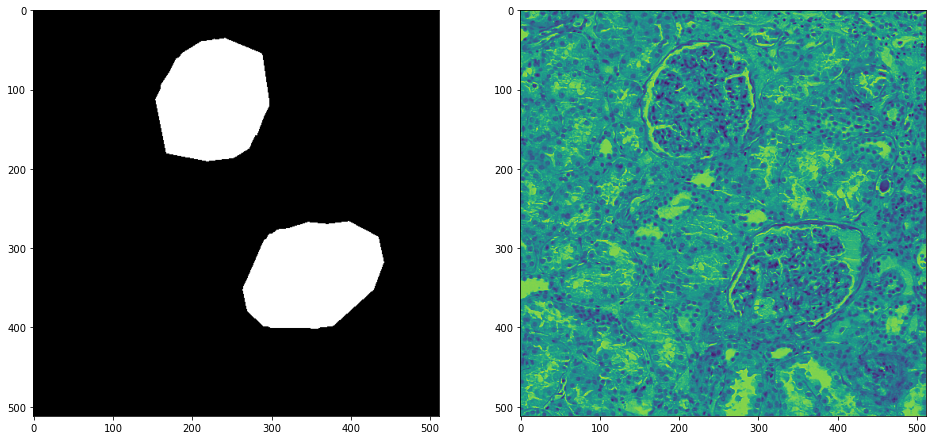

In [10]:
image, mask = ds[2]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

In [11]:
del image, mask
gc.collect()

4540

# B. Model

In [12]:
#https://github.com/qubvel/segmentation_models.pytorch#encoders
ENCODER = 'resnext50_32x4d' #efficientnet-b4
ENCODER_WEIGHTS = 'imagenet' #ssl, swsl
ACTIVATION = 'sigmoid' 
DROPOUT = 0.5
POOLING = 'avg'

def get_model():
    model = smp.Unet( #UnetPlusPlus
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS,
        activation=ACTIVATION,
        in_channels=3,
        classes=1)
    #dropout=DROPOUT,
    #pooling=POOLING
    
    return model

In [13]:
def loss_fn(y_pred, y_true):
    bce = bce_loss(y_pred, y_true)
    dice = dice_loss(y_pred, y_true)
    return 0.4*bce+ 0.6*dice

In [14]:
### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         loss            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'

In [15]:
valid_idx, train_idx = [], []
for i in range(len(ds)):
    if ds.slices[i][0] == 7:
        valid_idx.append(i)
    else:
        train_idx.append(i)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth




        Train | Valid
Epoch |  Loss |  Loss | Time, m

     0│  0.616│  0.727│  1.89
Model saved!
     1│  0.517│  0.651│  1.86
Model saved!
     2│  0.471│  0.727│  1.86
     3│  0.420│  0.558│  1.87
Model saved!
     4│  0.377│  0.406│  1.85
Model saved!
     5│  0.398│  0.414│  1.86
     6│  0.365│  0.432│  1.86
     7│  0.358│  0.395│  1.86
Model saved!
     8│  0.348│  0.366│  1.86
Model saved!
     9│  0.345│  0.358│  1.87
Model saved!
    10│  0.362│  0.418│  1.86
    11│  0.366│  0.601│  1.86
    12│  0.359│  0.435│  1.86
    13│  0.360│  0.410│  1.86
    14│  0.352│  0.399│  1.86


<Figure size 720x504 with 0 Axes>

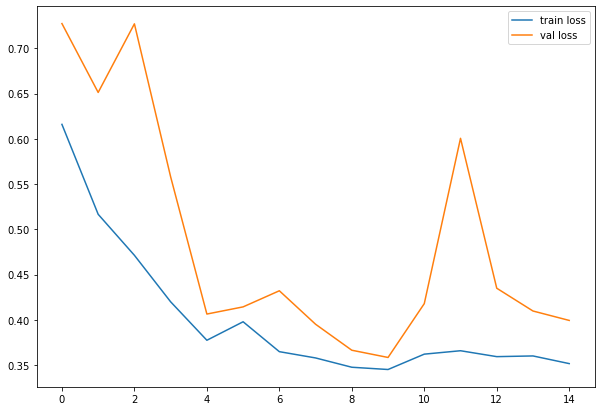

In [16]:
plt.figure(figsize=(10,7))

#skf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
#for fold,(train_idx, valid_idx) in enumerate(skf.split(ds)):
#dataset
train_ds = D.Subset(ds, train_idx)
valid_ds = D.Subset(ds, valid_idx)

#dataloader
train_loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
val_loader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)

#model
model = get_model()
model.to(DEVICE)
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = smp.utils.losses.DiceLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2)

best_loss = 5
print(header)
trains = []
vals = []
for epoch in range(EPOCHS):
    train_losses, val_losses = [], []
    start_time = time.time()

    model.train()
    for image, target in train_loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
    model.eval()

    with torch.no_grad():
        for image, target in val_loader:
            image, target = image.to(DEVICE), target.float().to(DEVICE)
            output = model(image)
            loss = loss_fn(output, target)
            val_losses.append(loss.item())

    train_loss = np.array(train_losses).mean()
    val_loss = np.array(val_losses).mean()
    trains.append(train_loss)
    vals.append(val_loss)
    print(raw_line.format(epoch, 
                          train_loss, 
                          val_loss,
                          (time.time()-start_time)/60**1))

    if best_loss > val_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, f'best_model.pth'))#_{fold}.pth'))
        print('Model saved!')

#plot
plt.figure(figsize=(10,7))
plt.plot(trains, label='train loss')
plt.plot(vals, label='val loss')
plt.legend()
plt.show();  

In [17]:
del train_ds, valid_ds, train_loader, val_loader, model
gc.collect()

3075

In [18]:
best_model = torch.load(os.path.join(SAVE_DIR, 'best_model.pth'), map_location=torch.device(DEVICE))

In [19]:
best_model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'